# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch

In [6]:
import numba.cuda

In [7]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [8]:
decoys = tmol.tests.data.structures_bysize()

In [9]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame

def benchmark_rosetta_scores(decoys):
    stats = []
    
    for n, d in decoys.items():
        logging.info(n)
        work_pose = d.stripped_pose.pose
        
        fixture = make_fixture("score", stats.append, nres=len(work_pose.residues), model = n)
        
        logging.info("Rosetta")
        #fsf = pyrosetta.get_score_function()
        #def rosetta_noclear():
        #    return fsf(work_pose)
        #
        #def rosetta_clear():
        #    work_pose.energies().clear()
        #    return fsf(work_pose)
        #
        #null_sf = pyrosetta.get_score_function()
        #for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        #    null_sf.set_weight(v, 0)
        #
        #def rosetta_null():
        #    work_pose.energies().clear()
        #    return null_sf(work_pose)
        #
        #def rosetta_full():
        #    work_pose.energies().clear_energies()
        #    return fsf(work_pose)
        
        atr_rep_sf = pyrosetta.get_score_function()
        for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
            if k not in ("fa_atr", "fa_rep"):
                atr_rep_sf.set_weight(v, 0)
                
        @subfixture(fixture) 
        def rosetta_atr_rep():
            work_pose.energies().clear()
            return atr_rep_sf(work_pose)
        
        @reactive_attrs
        class TMolLJLK(
            tmol.score.ljlk.LJLKScoreGraph,
            tmol.score.interatomic_distance.BlockedInteratomicDistanceGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass
        
        @reactive_attrs
        class TMolJitLJLK(
            tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass
        
        score_graphs = dict(
            tmol_lj_cpu = TMolLJLK.build_for(d.tmol_system, requires_grad=False),
            tmol_lj_cpu_jit = TMolJitLJLK.build_for(d.tmol_system, requires_grad=False),
            tmol_lj_cuda = TMolLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
            tmol_lj_cuda_jit = TMolJitLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
        )
        
        scores = {}
        
        for n, sg in score_graphs.items():
            # Bypass errors w/ cuda memory
            if len(work_pose.residues) > 500 and n is "tmol_lj_cuda":
                continue

            logging.info(f"{n}")
            # Setup graph
            sg.intra_score().total_lj
            
            @make_subfixture(fixture, f".{n}")
            def benchmark_score_graph():
                sg.coords = sg.coords
                return float(sg.intra_score().total_lj)
            
            scores[n] = benchmark_score_graph
            
        del score_graphs
        torch.cuda.empty_cache()
        
        tmol_scores = " ".join(f"{n}: {v}" for n, v in scores.items())
        
        logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")
        
    return stats

In [10]:
rosetta_score_results = benchmark_rosetta_scores(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:numba.cuda.cudadrv.driver:init
INFO:root:rosetta: -1653.4115141856676 tmol_lj_cpu: 710.3541870117188 tmol_lj_cpu_jit: 710.354248046875 tmol_lj_cuda: 710.3544311523438 tmol_lj_cuda_jit: 710.45849609375
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:root:rosetta: -954.3679023401932 tmol_lj_cpu: -690.8179321289062 tmol_lj_cpu_jit: -690.8179321289062 tmol_lj_cuda: -690.8179321289062 tmol_lj_cuda_jit: -693.1591796875
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:Rosetta
INFO:root:tmol_lj_cpu
INFO:root:tmol_lj_cpu_jit
INFO:root:tmol_lj_cuda
INFO:root:tmol_lj_cuda_jit
INFO:root:rosetta: -1119.8932213914081 tmol_lj_cpu: -716.195373

In [15]:
from matplotlib import pyplot
import seaborn
import pandas

In [16]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

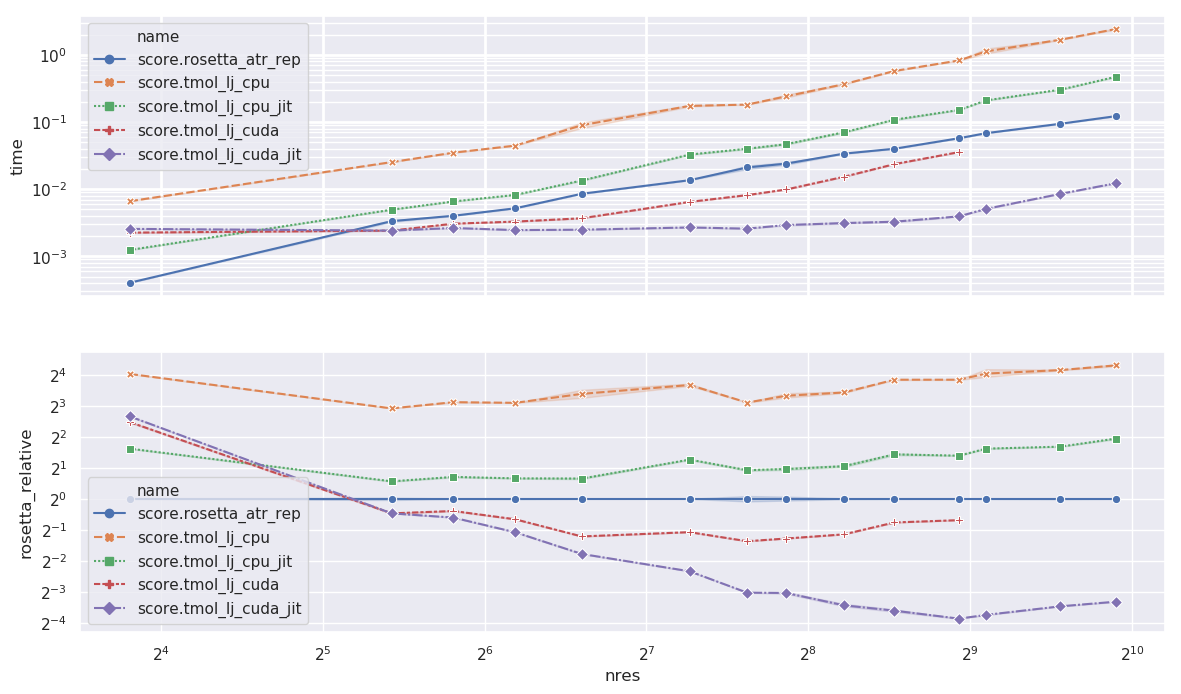

In [17]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="name", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "rosetta_relative", data=dat, hue="name", style="name", markers=True)

In [22]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("nres")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("nres", "name"))[["rosetta_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

,mean,max,std
,time,time,time
nres,,,
14,0.000404,0.001151,0.000021
43,0.003342,0.004875,0.000482
56,0.004016,0.006323,0.000274
73,0.005193,0.008468,0.000318
97,0.008539,0.008836,0.000091
154,0.013607,0.014277,0.000099
197,0.021054,0.029727,0.003415
233,0.024024,0.033084,0.002790


mean                        max  \
                            rosetta_relative      time rosetta_relative   
nres name                                                                 
14   score.rosetta_atr_rep          1.000000  0.000404         2.849190   
     score.tmol_lj_cpu             16.386359  0.006619        19.489334   
     score.tmol_lj_cpu_jit          3.079495  0.001244         7.730251   
     score.tmol_lj_cuda             5.579758  0.002254         6.867941   
     score.tmol_lj_cuda_jit         6.345057  0.002563         8.524907   
43   score.rosetta_atr_rep          1.000000  0.003342         1.458551   
     score.tmol_lj_cpu              7.575141  0.025319         7.677685   
     score.tmol_lj_cpu_jit          1.480878  0.004950         2.074685   
     score.tmol_lj_cuda             0.723016  0.002417         0.893269   
     score.tmol_lj_cuda_jit         0.723355  0.002418         0.948182   
56   score.rosetta_atr_rep          1.000000  0.004016         1.574688   
     score.tmol_lj_cpu              8.705619  0.034959         9.820696   
     score.tmol_lj_cpu_jit          1.634740  0.006565         2.324779   
     score.tmol_lj_cuda             0.762767  0.003063         1.436213   
     score.tmol_lj_cuda_jit         0.657856  0.002642         0.731780   
73   score.rosetta_atr_rep          1.000000  0.005193         1.630770   
     score.tmol_lj_cpu              8.581474  0.044560         8.616685   
     score.tmol_lj_cpu_jit          1.582780  0.008219         2.155411   
     score.tmol_lj_cuda             0.633386  0.003289         0.701327   
     score.tmol_lj_cuda_jit         0.473534  0.002459         0.719306   
97   score.rosetta_atr_rep          1.000000  0.008539         1.034795   
     score.tmol_lj_cpu             10.479645  0.089487        14.815757   
     score.tmol_lj_cpu_jit          1.574965  0.013449         2.308070   
     score.tmol_lj_cuda             0.431625  0.003686         0.512129   
     score.tmol_lj_cuda_jit         0.291824  0.002492         0.403747   
154  score.rosetta_atr_rep          1.000000  0.013607         1.049270   
     score.tmol_lj_cpu             12.783890  0.173951        13.698057   
     score.tmol_lj_cpu_jit          2.407831  0.032763         2.630033   
     score.tmol_lj_cuda             0.475005  0.006463         0.482171   
     score.tmol_lj_cuda_jit         0.197853  0.002692         0.240458   
...                                      ...       ...              ...   
233  score.tmol_lj_cpu_jit          1.949948  0.046846         2.459160   
     score.tmol_lj_cuda             0.411956  0.009897         0.414045   
     score.tmol_lj_cuda_jit         0.121779  0.002926         0.301827   
298  score.rosetta_atr_rep          1.000000  0.033799         1.085917   
     score.tmol_lj_cpu             10.813450  0.365483        11.072927   
     score.tmol_lj_cpu_jit          2.077246  0.070209         2.283738   
     score.tmol_lj_cuda             0.452092  0.015280         0.482976   
     score.tmol_lj_cuda_jit         0.092400  0.003123         0.490675   
370  score.rosetta_atr_rep          1.000000  0.039984         1.044169   
     score.tmol_lj_cpu             14.390358  0.575384        14.470231   
     score.tmol_lj_cpu_jit          2.707366  0.108251         2.953167   
     score.tmol_lj_cuda             0.589848  0.023584         0.607370   
     score.tmol_lj_cuda_jit         0.081981  0.003278         0.211689   
488  score.rosetta_atr_rep          1.000000  0.057378         1.017983   
     score.tmol_lj_cpu             14.392737  0.825822        14.477015   
     score.tmol_lj_cpu_jit          2.630219  0.150916         2.675215   
     score.tmol_lj_cuda             0.621379  0.035653         0.638448   
     score.tmol_lj_cuda_jit         0.068562  0.003934         0.107586   
548  score.rosetta_atr_rep          1.000000  0.068235         1.023890   
     score.tmol_lj_cpu             16.493481  1.125427        18.